# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

FileNotFoundError: [Errno 2] No such file or directory: 'data/train_32x32.mat'

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [4]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [5]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))
# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [8]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

[1 0 0]
[ 1.          0.36787944  0.36787944]
[ 1.  0.  0.]
[ 1.          0.36787944  0.36787944]
[ 1.  0.  0.] [ 1.  0.  0.]
[ 1.00001  0.       0.     ]
[ 1.          0.36787576  0.36787576]
[ 0.99999  0.       0.     ]
[ 1.          0.36788312  0.36788312]
[  1.00000000e+00   1.00000000e-05   0.00000000e+00]
[ 1.          0.36788312  0.36787944]
[  1.00000000e+00  -1.00000000e-05   0.00000000e+00]
[ 1.          0.36787576  0.36787944]
[  1.00000000e+00   0.00000000e+00   1.00000000e-05]
[ 1.          0.36787944  0.36788312]
[  1.00000000e+00   0.00000000e+00  -1.00000000e-05]
[ 1.          0.36787944  0.36787576]
Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [108]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [120]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [126]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [132]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.301635
Epoch 1, loss: 2.301370
Epoch 2, loss: 2.302246
Epoch 3, loss: 2.300777
Epoch 4, loss: 2.301828
Epoch 5, loss: 2.301572
Epoch 6, loss: 2.301314
Epoch 7, loss: 2.300921
Epoch 8, loss: 2.301757
Epoch 9, loss: 2.300814


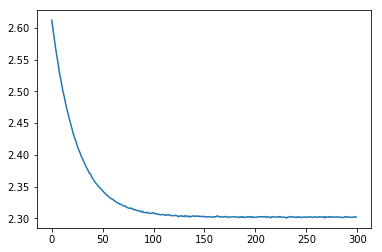

In [133]:
# let's look at the loss history!
plt.plot(loss_history)

In [145]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.123
Epoch 0, loss: 2.300982
Epoch 1, loss: 2.300825
Epoch 2, loss: 2.301206
Epoch 3, loss: 2.300081
Epoch 4, loss: 2.301134
Epoch 5, loss: 2.300561
Epoch 6, loss: 2.301291
Epoch 7, loss: 2.300930
Epoch 8, loss: 2.301077
Epoch 9, loss: 2.301322
Epoch 10, loss: 2.301178
Epoch 11, loss: 2.300902
Epoch 12, loss: 2.301416
Epoch 13, loss: 2.301199
Epoch 14, loss: 2.300990
Epoch 15, loss: 2.300628
Epoch 16, loss: 2.301861
Epoch 17, loss: 2.301094
Epoch 18, loss: 2.301304
Epoch 19, loss: 2.300730
Epoch 20, loss: 2.301783
Epoch 21, loss: 2.301461
Epoch 22, loss: 2.300534
Epoch 23, loss: 2.301454
Epoch 24, loss: 2.301530
Epoch 25, loss: 2.300549
Epoch 26, loss: 2.301465
Epoch 27, loss: 2.301265
Epoch 28, loss: 2.301255
Epoch 29, loss: 2.299870
Epoch 30, loss: 2.300867
Epoch 31, loss: 2.300668
Epoch 32, loss: 2.300680
Epoch 33, loss: 2.300366
Epoch 34, loss: 2.300326
Epoch 35, loss: 2.301552
Epoch 36, loss: 2.301035
Epoch 37, loss: 2.301820
Epoch 38, loss: 2.301173
Epoch 39, loss: 2.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [154]:
for lr, reg in list(product(*(learning_rates, reg_strengths))):
    print(lr, reg)

0.001 0.0001
0.001 1e-05
0.001 1e-06
0.0001 0.0001
0.0001 1e-05
0.0001 1e-06
1e-05 0.0001
1e-05 1e-05
1e-05 1e-06


In [159]:
num_epochs = 200
batch_size = 300

learning_rates = np.linspace(1e-2, 1e-6, 10)
reg_strengths = np.linspace(1e-3, 1e-7, 10)

best_params = None
best_val_accuracy = 0


for lr, reg in list(product(*(learning_rates, reg_strengths))):
    classifier = linear_classifer.LinearSoftmaxClassifier()
    classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, batch_size=batch_size, reg=reg)
    pred = classifier.predict(val_X)
    accuracy = multiclass_accuracy(pred, val_y)
    
    if accuracy > best_val_accuracy:
        best_classifier = classifier
        best_val_accuracy = accuracy
        best_params = {'reg': reg, 'lr': lr}
        
print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 2.296647
Epoch 1, loss: 2.291365
Epoch 2, loss: 2.281522
Epoch 3, loss: 2.275074
Epoch 4, loss: 2.271867
Epoch 5, loss: 2.265529
Epoch 6, loss: 2.262983
Epoch 7, loss: 2.241321
Epoch 8, loss: 2.240361
Epoch 9, loss: 2.231120
Epoch 10, loss: 2.222720
Epoch 11, loss: 2.210999
Epoch 12, loss: 2.247007
Epoch 13, loss: 2.215775
Epoch 14, loss: 2.224914
Epoch 15, loss: 2.248927
Epoch 16, loss: 2.207161
Epoch 17, loss: 2.240505
Epoch 18, loss: 2.214672
Epoch 19, loss: 2.205035
Epoch 20, loss: 2.199804
Epoch 21, loss: 2.192271
Epoch 22, loss: 2.208212
Epoch 23, loss: 2.181064
Epoch 24, loss: 2.146503
Epoch 25, loss: 2.196411
Epoch 26, loss: 2.182351
Epoch 27, loss: 2.194948
Epoch 28, loss: 2.193163
Epoch 29, loss: 2.171988
Epoch 30, loss: 2.191856
Epoch 31, loss: 2.155835
Epoch 32, loss: 2.182851
Epoch 33, loss: 2.179653
Epoch 34, loss: 2.167582
Epoch 35, loss: 2.170617
Epoch 36, loss: 2.157368
Epoch 37, loss: 2.153610
Epoch 38, loss: 2.171463
Epoch 39, loss: 2.181112
Epoch 40, 

Epoch 124, loss: 2.113307
Epoch 125, loss: 2.084228
Epoch 126, loss: 2.100583
Epoch 127, loss: 2.078394
Epoch 128, loss: 2.100979
Epoch 129, loss: 2.084724
Epoch 130, loss: 2.144136
Epoch 131, loss: 2.118049
Epoch 132, loss: 2.141216
Epoch 133, loss: 2.144638
Epoch 134, loss: 2.113492
Epoch 135, loss: 2.072895
Epoch 136, loss: 2.074772
Epoch 137, loss: 2.077622
Epoch 138, loss: 2.148447
Epoch 139, loss: 2.114630
Epoch 140, loss: 2.122045
Epoch 141, loss: 2.096658
Epoch 142, loss: 2.118553
Epoch 143, loss: 2.162031
Epoch 144, loss: 2.144872
Epoch 145, loss: 2.124778
Epoch 146, loss: 2.134686
Epoch 147, loss: 2.108466
Epoch 148, loss: 2.051012
Epoch 149, loss: 2.116317
Epoch 150, loss: 2.198473
Epoch 151, loss: 2.124159
Epoch 152, loss: 2.108794
Epoch 153, loss: 2.111365
Epoch 154, loss: 2.070496
Epoch 155, loss: 2.044674
Epoch 156, loss: 2.114628
Epoch 157, loss: 2.085379
Epoch 158, loss: 2.128550
Epoch 159, loss: 2.089535
Epoch 160, loss: 2.147440
Epoch 161, loss: 2.122615
Epoch 162, l

Epoch 46, loss: 2.170140
Epoch 47, loss: 2.171898
Epoch 48, loss: 2.151340
Epoch 49, loss: 2.153140
Epoch 50, loss: 2.179552
Epoch 51, loss: 2.185722
Epoch 52, loss: 2.183380
Epoch 53, loss: 2.198976
Epoch 54, loss: 2.140145
Epoch 55, loss: 2.144663
Epoch 56, loss: 2.097930
Epoch 57, loss: 2.135702
Epoch 58, loss: 2.187359
Epoch 59, loss: 2.162196
Epoch 60, loss: 2.152076
Epoch 61, loss: 2.167937
Epoch 62, loss: 2.120760
Epoch 63, loss: 2.130058
Epoch 64, loss: 2.085233
Epoch 65, loss: 2.173521
Epoch 66, loss: 2.150541
Epoch 67, loss: 2.137503
Epoch 68, loss: 2.101499
Epoch 69, loss: 2.113725
Epoch 70, loss: 2.141944
Epoch 71, loss: 2.112746
Epoch 72, loss: 2.148615
Epoch 73, loss: 2.119873
Epoch 74, loss: 2.129657
Epoch 75, loss: 2.139332
Epoch 76, loss: 2.135432
Epoch 77, loss: 2.170343
Epoch 78, loss: 2.112635
Epoch 79, loss: 2.165179
Epoch 80, loss: 2.129554
Epoch 81, loss: 2.207516
Epoch 82, loss: 2.128098
Epoch 83, loss: 2.108261
Epoch 84, loss: 2.161065
Epoch 85, loss: 2.142885


Epoch 169, loss: 2.101600
Epoch 170, loss: 2.156996
Epoch 171, loss: 2.074175
Epoch 172, loss: 2.058781
Epoch 173, loss: 2.118809
Epoch 174, loss: 2.117881
Epoch 175, loss: 2.103368
Epoch 176, loss: 2.105660
Epoch 177, loss: 2.137091
Epoch 178, loss: 2.050093
Epoch 179, loss: 2.019713
Epoch 180, loss: 2.134238
Epoch 181, loss: 2.130881
Epoch 182, loss: 2.081758
Epoch 183, loss: 2.116008
Epoch 184, loss: 2.097385
Epoch 185, loss: 2.072296
Epoch 186, loss: 2.131112
Epoch 187, loss: 2.135456
Epoch 188, loss: 2.163097
Epoch 189, loss: 2.129753
Epoch 190, loss: 2.067470
Epoch 191, loss: 2.096754
Epoch 192, loss: 2.104420
Epoch 193, loss: 2.110174
Epoch 194, loss: 2.089951
Epoch 195, loss: 2.084218
Epoch 196, loss: 2.137956
Epoch 197, loss: 2.077886
Epoch 198, loss: 2.075654
Epoch 199, loss: 2.044868
Epoch 0, loss: 2.296921
Epoch 1, loss: 2.294589
Epoch 2, loss: 2.278440
Epoch 3, loss: 2.272601
Epoch 4, loss: 2.258419
Epoch 5, loss: 2.266841
Epoch 6, loss: 2.249573
Epoch 7, loss: 2.251430
Ep

Epoch 93, loss: 2.142867
Epoch 94, loss: 2.142989
Epoch 95, loss: 2.153476
Epoch 96, loss: 2.119006
Epoch 97, loss: 2.159461
Epoch 98, loss: 2.149610
Epoch 99, loss: 2.143074
Epoch 100, loss: 2.091303
Epoch 101, loss: 2.117773
Epoch 102, loss: 2.080704
Epoch 103, loss: 2.165975
Epoch 104, loss: 2.109797
Epoch 105, loss: 2.139906
Epoch 106, loss: 2.089857
Epoch 107, loss: 2.213946
Epoch 108, loss: 2.214492
Epoch 109, loss: 2.183221
Epoch 110, loss: 2.125516
Epoch 111, loss: 2.158952
Epoch 112, loss: 2.129262
Epoch 113, loss: 2.105907
Epoch 114, loss: 2.082601
Epoch 115, loss: 2.161401
Epoch 116, loss: 2.130730
Epoch 117, loss: 2.141730
Epoch 118, loss: 2.118123
Epoch 119, loss: 2.083100
Epoch 120, loss: 2.104986
Epoch 121, loss: 2.156463
Epoch 122, loss: 2.149670
Epoch 123, loss: 2.087238
Epoch 124, loss: 2.130018
Epoch 125, loss: 2.114573
Epoch 126, loss: 2.165492
Epoch 127, loss: 2.079921
Epoch 128, loss: 2.130730
Epoch 129, loss: 2.117429
Epoch 130, loss: 2.074730
Epoch 131, loss: 2.

Epoch 14, loss: 2.220232
Epoch 15, loss: 2.199483
Epoch 16, loss: 2.225377
Epoch 17, loss: 2.216811
Epoch 18, loss: 2.187812
Epoch 19, loss: 2.232927
Epoch 20, loss: 2.186362
Epoch 21, loss: 2.240908
Epoch 22, loss: 2.205630
Epoch 23, loss: 2.183359
Epoch 24, loss: 2.199415
Epoch 25, loss: 2.156502
Epoch 26, loss: 2.194302
Epoch 27, loss: 2.188371
Epoch 28, loss: 2.169175
Epoch 29, loss: 2.168991
Epoch 30, loss: 2.175627
Epoch 31, loss: 2.171604
Epoch 32, loss: 2.202608
Epoch 33, loss: 2.145998
Epoch 34, loss: 2.163067
Epoch 35, loss: 2.180496
Epoch 36, loss: 2.130268
Epoch 37, loss: 2.129352
Epoch 38, loss: 2.180303
Epoch 39, loss: 2.171518
Epoch 40, loss: 2.178821
Epoch 41, loss: 2.169371
Epoch 42, loss: 2.132906
Epoch 43, loss: 2.196990
Epoch 44, loss: 2.200499
Epoch 45, loss: 2.148047
Epoch 46, loss: 2.148088
Epoch 47, loss: 2.173283
Epoch 48, loss: 2.116059
Epoch 49, loss: 2.142347
Epoch 50, loss: 2.126298
Epoch 51, loss: 2.155652
Epoch 52, loss: 2.139737
Epoch 53, loss: 2.130212


Epoch 138, loss: 2.109557
Epoch 139, loss: 2.075102
Epoch 140, loss: 2.098089
Epoch 141, loss: 2.084036
Epoch 142, loss: 2.101415
Epoch 143, loss: 2.150337
Epoch 144, loss: 2.115551
Epoch 145, loss: 2.100064
Epoch 146, loss: 2.150258
Epoch 147, loss: 2.075809
Epoch 148, loss: 2.120722
Epoch 149, loss: 2.110782
Epoch 150, loss: 2.080497
Epoch 151, loss: 2.026187
Epoch 152, loss: 2.139640
Epoch 153, loss: 2.115380
Epoch 154, loss: 2.168991
Epoch 155, loss: 2.109553
Epoch 156, loss: 2.083484
Epoch 157, loss: 2.112362
Epoch 158, loss: 2.084301
Epoch 159, loss: 2.099078
Epoch 160, loss: 2.133089
Epoch 161, loss: 2.054645
Epoch 162, loss: 2.188056
Epoch 163, loss: 2.085693
Epoch 164, loss: 2.073236
Epoch 165, loss: 2.085287
Epoch 166, loss: 2.070981
Epoch 167, loss: 2.052238
Epoch 168, loss: 2.148653
Epoch 169, loss: 2.061715
Epoch 170, loss: 2.129998
Epoch 171, loss: 2.088559
Epoch 172, loss: 2.136677
Epoch 173, loss: 2.088459
Epoch 174, loss: 2.136361
Epoch 175, loss: 2.082117
Epoch 176, l

Epoch 61, loss: 2.144120
Epoch 62, loss: 2.154406
Epoch 63, loss: 2.182125
Epoch 64, loss: 2.163818
Epoch 65, loss: 2.205061
Epoch 66, loss: 2.126925
Epoch 67, loss: 2.105008
Epoch 68, loss: 2.175008
Epoch 69, loss: 2.166006
Epoch 70, loss: 2.153590
Epoch 71, loss: 2.123767
Epoch 72, loss: 2.148520
Epoch 73, loss: 2.159463
Epoch 74, loss: 2.142640
Epoch 75, loss: 2.169360
Epoch 76, loss: 2.157481
Epoch 77, loss: 2.134312
Epoch 78, loss: 2.179751
Epoch 79, loss: 2.142634
Epoch 80, loss: 2.161911
Epoch 81, loss: 2.176324
Epoch 82, loss: 2.088797
Epoch 83, loss: 2.151936
Epoch 84, loss: 2.135906
Epoch 85, loss: 2.170612
Epoch 86, loss: 2.181937
Epoch 87, loss: 2.125269
Epoch 88, loss: 2.093935
Epoch 89, loss: 2.148326
Epoch 90, loss: 2.171624
Epoch 91, loss: 2.110875
Epoch 92, loss: 2.130987
Epoch 93, loss: 2.117860
Epoch 94, loss: 2.142533
Epoch 95, loss: 2.069732
Epoch 96, loss: 2.166804
Epoch 97, loss: 2.078721
Epoch 98, loss: 2.132331
Epoch 99, loss: 2.169864
Epoch 100, loss: 2.171450

Epoch 183, loss: 2.120114
Epoch 184, loss: 2.096391
Epoch 185, loss: 2.109279
Epoch 186, loss: 2.093642
Epoch 187, loss: 2.069242
Epoch 188, loss: 2.154911
Epoch 189, loss: 2.112146
Epoch 190, loss: 2.132096
Epoch 191, loss: 2.075659
Epoch 192, loss: 2.102745
Epoch 193, loss: 2.139731
Epoch 194, loss: 2.130566
Epoch 195, loss: 2.116552
Epoch 196, loss: 2.118965
Epoch 197, loss: 2.164600
Epoch 198, loss: 2.070765
Epoch 199, loss: 2.163645
Epoch 0, loss: 2.296686
Epoch 1, loss: 2.290190
Epoch 2, loss: 2.281009
Epoch 3, loss: 2.282181
Epoch 4, loss: 2.267013
Epoch 5, loss: 2.266337
Epoch 6, loss: 2.253100
Epoch 7, loss: 2.245571
Epoch 8, loss: 2.256105
Epoch 9, loss: 2.253980
Epoch 10, loss: 2.224468
Epoch 11, loss: 2.252051
Epoch 12, loss: 2.231989
Epoch 13, loss: 2.229325
Epoch 14, loss: 2.225889
Epoch 15, loss: 2.219908
Epoch 16, loss: 2.199542
Epoch 17, loss: 2.195497
Epoch 18, loss: 2.231844
Epoch 19, loss: 2.233280
Epoch 20, loss: 2.234283
Epoch 21, loss: 2.214269
Epoch 22, loss: 2.

Epoch 108, loss: 2.065044
Epoch 109, loss: 2.146059
Epoch 110, loss: 2.110467
Epoch 111, loss: 2.119529
Epoch 112, loss: 2.133180
Epoch 113, loss: 2.114486
Epoch 114, loss: 2.158627
Epoch 115, loss: 2.098191
Epoch 116, loss: 2.143397
Epoch 117, loss: 2.084093
Epoch 118, loss: 2.147666
Epoch 119, loss: 2.108956
Epoch 120, loss: 2.066591
Epoch 121, loss: 2.106816
Epoch 122, loss: 2.123978
Epoch 123, loss: 2.121553
Epoch 124, loss: 2.172355
Epoch 125, loss: 2.141990
Epoch 126, loss: 2.168437
Epoch 127, loss: 2.072169
Epoch 128, loss: 2.142188
Epoch 129, loss: 2.180594
Epoch 130, loss: 2.185542
Epoch 131, loss: 2.055171
Epoch 132, loss: 2.118312
Epoch 133, loss: 2.097810
Epoch 134, loss: 2.129112
Epoch 135, loss: 2.152704
Epoch 136, loss: 2.120300
Epoch 137, loss: 2.162057
Epoch 138, loss: 2.120153
Epoch 139, loss: 2.173348
Epoch 140, loss: 2.081808
Epoch 141, loss: 2.187362
Epoch 142, loss: 2.126624
Epoch 143, loss: 2.089748
Epoch 144, loss: 2.143292
Epoch 145, loss: 2.133819
Epoch 146, l

Epoch 29, loss: 2.198192
Epoch 30, loss: 2.197766
Epoch 31, loss: 2.174667
Epoch 32, loss: 2.159478
Epoch 33, loss: 2.199225
Epoch 34, loss: 2.209313
Epoch 35, loss: 2.163023
Epoch 36, loss: 2.138131
Epoch 37, loss: 2.165115
Epoch 38, loss: 2.208811
Epoch 39, loss: 2.169502
Epoch 40, loss: 2.191624
Epoch 41, loss: 2.201324
Epoch 42, loss: 2.149677
Epoch 43, loss: 2.210417
Epoch 44, loss: 2.192070
Epoch 45, loss: 2.170411
Epoch 46, loss: 2.174719
Epoch 47, loss: 2.207235
Epoch 48, loss: 2.157954
Epoch 49, loss: 2.192689
Epoch 50, loss: 2.141712
Epoch 51, loss: 2.149575
Epoch 52, loss: 2.165212
Epoch 53, loss: 2.153224
Epoch 54, loss: 2.145500
Epoch 55, loss: 2.142096
Epoch 56, loss: 2.130548
Epoch 57, loss: 2.166026
Epoch 58, loss: 2.165147
Epoch 59, loss: 2.195599
Epoch 60, loss: 2.165635
Epoch 61, loss: 2.172284
Epoch 62, loss: 2.125948
Epoch 63, loss: 2.156803
Epoch 64, loss: 2.220553
Epoch 65, loss: 2.149111
Epoch 66, loss: 2.130700
Epoch 67, loss: 2.122207
Epoch 68, loss: 2.170581


Epoch 152, loss: 2.065581
Epoch 153, loss: 2.138418
Epoch 154, loss: 2.116260
Epoch 155, loss: 2.116709
Epoch 156, loss: 2.087103
Epoch 157, loss: 2.095277
Epoch 158, loss: 2.080284
Epoch 159, loss: 2.108499
Epoch 160, loss: 2.147927
Epoch 161, loss: 2.105712
Epoch 162, loss: 2.200236
Epoch 163, loss: 2.112296
Epoch 164, loss: 2.078562
Epoch 165, loss: 2.133786
Epoch 166, loss: 2.124118
Epoch 167, loss: 2.069324
Epoch 168, loss: 2.067361
Epoch 169, loss: 2.095612
Epoch 170, loss: 2.110320
Epoch 171, loss: 2.126558
Epoch 172, loss: 2.169632
Epoch 173, loss: 2.191020
Epoch 174, loss: 2.094954
Epoch 175, loss: 2.127599
Epoch 176, loss: 2.113417
Epoch 177, loss: 2.144299
Epoch 178, loss: 2.068249
Epoch 179, loss: 2.074825
Epoch 180, loss: 2.112823
Epoch 181, loss: 2.136469
Epoch 182, loss: 2.111230
Epoch 183, loss: 2.140406
Epoch 184, loss: 2.091498
Epoch 185, loss: 2.111712
Epoch 186, loss: 2.112947
Epoch 187, loss: 2.103055
Epoch 188, loss: 2.061305
Epoch 189, loss: 2.123093
Epoch 190, l

Epoch 76, loss: 2.137384
Epoch 77, loss: 2.131116
Epoch 78, loss: 2.170177
Epoch 79, loss: 2.182201
Epoch 80, loss: 2.128614
Epoch 81, loss: 2.171060
Epoch 82, loss: 2.180614
Epoch 83, loss: 2.207669
Epoch 84, loss: 2.148000
Epoch 85, loss: 2.125290
Epoch 86, loss: 2.135585
Epoch 87, loss: 2.139754
Epoch 88, loss: 2.118329
Epoch 89, loss: 2.119113
Epoch 90, loss: 2.132163
Epoch 91, loss: 2.154661
Epoch 92, loss: 2.092104
Epoch 93, loss: 2.151235
Epoch 94, loss: 2.127400
Epoch 95, loss: 2.135457
Epoch 96, loss: 2.136290
Epoch 97, loss: 2.156162
Epoch 98, loss: 2.167988
Epoch 99, loss: 2.124264
Epoch 100, loss: 2.141737
Epoch 101, loss: 2.101375
Epoch 102, loss: 2.190020
Epoch 103, loss: 2.150473
Epoch 104, loss: 2.132076
Epoch 105, loss: 2.130050
Epoch 106, loss: 2.168166
Epoch 107, loss: 2.153378
Epoch 108, loss: 2.139116
Epoch 109, loss: 2.167588
Epoch 110, loss: 2.046511
Epoch 111, loss: 2.135214
Epoch 112, loss: 2.065960
Epoch 113, loss: 2.112954
Epoch 114, loss: 2.084211
Epoch 115,

Epoch 197, loss: 2.160395
Epoch 198, loss: 2.087994
Epoch 199, loss: 2.134151
Epoch 0, loss: 2.291752
Epoch 1, loss: 2.295158
Epoch 2, loss: 2.282194
Epoch 3, loss: 2.281779
Epoch 4, loss: 2.262704
Epoch 5, loss: 2.270860
Epoch 6, loss: 2.261961
Epoch 7, loss: 2.248858
Epoch 8, loss: 2.256598
Epoch 9, loss: 2.247778
Epoch 10, loss: 2.251510
Epoch 11, loss: 2.247244
Epoch 12, loss: 2.232666
Epoch 13, loss: 2.253765
Epoch 14, loss: 2.239214
Epoch 15, loss: 2.226132
Epoch 16, loss: 2.228731
Epoch 17, loss: 2.220646
Epoch 18, loss: 2.213129
Epoch 19, loss: 2.212583
Epoch 20, loss: 2.202770
Epoch 21, loss: 2.245640
Epoch 22, loss: 2.234992
Epoch 23, loss: 2.219428
Epoch 24, loss: 2.195632
Epoch 25, loss: 2.204128
Epoch 26, loss: 2.201052
Epoch 27, loss: 2.200236
Epoch 28, loss: 2.232855
Epoch 29, loss: 2.194689
Epoch 30, loss: 2.194706
Epoch 31, loss: 2.187702
Epoch 32, loss: 2.187145
Epoch 33, loss: 2.168009
Epoch 34, loss: 2.211052
Epoch 35, loss: 2.177580
Epoch 36, loss: 2.181689
Epoch 3

Epoch 122, loss: 2.137790
Epoch 123, loss: 2.111101
Epoch 124, loss: 2.108801
Epoch 125, loss: 2.150063
Epoch 126, loss: 2.108545
Epoch 127, loss: 2.145502
Epoch 128, loss: 2.152005
Epoch 129, loss: 2.161115
Epoch 130, loss: 2.077336
Epoch 131, loss: 2.120332
Epoch 132, loss: 2.105972
Epoch 133, loss: 2.133774
Epoch 134, loss: 2.135499
Epoch 135, loss: 2.092157
Epoch 136, loss: 2.148443
Epoch 137, loss: 2.154415
Epoch 138, loss: 2.105526
Epoch 139, loss: 2.112083
Epoch 140, loss: 2.053441
Epoch 141, loss: 2.101594
Epoch 142, loss: 2.128791
Epoch 143, loss: 2.103059
Epoch 144, loss: 2.123387
Epoch 145, loss: 2.096270
Epoch 146, loss: 2.133439
Epoch 147, loss: 2.086387
Epoch 148, loss: 2.126859
Epoch 149, loss: 2.097439
Epoch 150, loss: 2.152050
Epoch 151, loss: 2.062144
Epoch 152, loss: 2.066159
Epoch 153, loss: 2.103127
Epoch 154, loss: 2.125225
Epoch 155, loss: 2.057873
Epoch 156, loss: 2.113170
Epoch 157, loss: 2.149930
Epoch 158, loss: 2.119519
Epoch 159, loss: 2.122911
Epoch 160, l

Epoch 45, loss: 2.188786
Epoch 46, loss: 2.158959
Epoch 47, loss: 2.187560
Epoch 48, loss: 2.152594
Epoch 49, loss: 2.180427
Epoch 50, loss: 2.143231
Epoch 51, loss: 2.143413
Epoch 52, loss: 2.198869
Epoch 53, loss: 2.144642
Epoch 54, loss: 2.156598
Epoch 55, loss: 2.153616
Epoch 56, loss: 2.192300
Epoch 57, loss: 2.142145
Epoch 58, loss: 2.174233
Epoch 59, loss: 2.151682
Epoch 60, loss: 2.141296
Epoch 61, loss: 2.132490
Epoch 62, loss: 2.171438
Epoch 63, loss: 2.195201
Epoch 64, loss: 2.179578
Epoch 65, loss: 2.194270
Epoch 66, loss: 2.135703
Epoch 67, loss: 2.117645
Epoch 68, loss: 2.099253
Epoch 69, loss: 2.096504
Epoch 70, loss: 2.168177
Epoch 71, loss: 2.115535
Epoch 72, loss: 2.162685
Epoch 73, loss: 2.149693
Epoch 74, loss: 2.146524
Epoch 75, loss: 2.152374
Epoch 76, loss: 2.150767
Epoch 77, loss: 2.155431
Epoch 78, loss: 2.098269
Epoch 79, loss: 2.138470
Epoch 80, loss: 2.191029
Epoch 81, loss: 2.124502
Epoch 82, loss: 2.123468
Epoch 83, loss: 2.153494
Epoch 84, loss: 2.185406


Epoch 167, loss: 2.121367
Epoch 168, loss: 2.153077
Epoch 169, loss: 2.077256
Epoch 170, loss: 2.149730
Epoch 171, loss: 2.111761
Epoch 172, loss: 2.150084
Epoch 173, loss: 2.070725
Epoch 174, loss: 2.138982
Epoch 175, loss: 2.063447
Epoch 176, loss: 2.097878
Epoch 177, loss: 2.057017
Epoch 178, loss: 2.127485
Epoch 179, loss: 2.117231
Epoch 180, loss: 2.142959
Epoch 181, loss: 2.085950
Epoch 182, loss: 2.089744
Epoch 183, loss: 2.103908
Epoch 184, loss: 2.128241
Epoch 185, loss: 2.083412
Epoch 186, loss: 2.031239
Epoch 187, loss: 2.049515
Epoch 188, loss: 2.103267
Epoch 189, loss: 2.120037
Epoch 190, loss: 2.083658
Epoch 191, loss: 2.075383
Epoch 192, loss: 2.086149
Epoch 193, loss: 2.104919
Epoch 194, loss: 2.108374
Epoch 195, loss: 2.125018
Epoch 196, loss: 2.122476
Epoch 197, loss: 2.113968
Epoch 198, loss: 2.093174
Epoch 199, loss: 2.080828
Epoch 0, loss: 2.293797
Epoch 1, loss: 2.293675
Epoch 2, loss: 2.288835
Epoch 3, loss: 2.285509
Epoch 4, loss: 2.268491
Epoch 5, loss: 2.27142

Epoch 92, loss: 2.204100
Epoch 93, loss: 2.147973
Epoch 94, loss: 2.119932
Epoch 95, loss: 2.119902
Epoch 96, loss: 2.117917
Epoch 97, loss: 2.103877
Epoch 98, loss: 2.170071
Epoch 99, loss: 2.089530
Epoch 100, loss: 2.168745
Epoch 101, loss: 2.155532
Epoch 102, loss: 2.186500
Epoch 103, loss: 2.155997
Epoch 104, loss: 2.145468
Epoch 105, loss: 2.158123
Epoch 106, loss: 2.113475
Epoch 107, loss: 2.108476
Epoch 108, loss: 2.087902
Epoch 109, loss: 2.162278
Epoch 110, loss: 2.127572
Epoch 111, loss: 2.140221
Epoch 112, loss: 2.115296
Epoch 113, loss: 2.129747
Epoch 114, loss: 2.113462
Epoch 115, loss: 2.108010
Epoch 116, loss: 2.162065
Epoch 117, loss: 2.115003
Epoch 118, loss: 2.101861
Epoch 119, loss: 2.206243
Epoch 120, loss: 2.133635
Epoch 121, loss: 2.172134
Epoch 122, loss: 2.154247
Epoch 123, loss: 2.158017
Epoch 124, loss: 2.161223
Epoch 125, loss: 2.093749
Epoch 126, loss: 2.127042
Epoch 127, loss: 2.172641
Epoch 128, loss: 2.136465
Epoch 129, loss: 2.102143
Epoch 130, loss: 2.1

Epoch 13, loss: 2.244976
Epoch 14, loss: 2.221592
Epoch 15, loss: 2.231667
Epoch 16, loss: 2.227379
Epoch 17, loss: 2.244064
Epoch 18, loss: 2.222998
Epoch 19, loss: 2.198566
Epoch 20, loss: 2.221289
Epoch 21, loss: 2.226254
Epoch 22, loss: 2.215813
Epoch 23, loss: 2.184610
Epoch 24, loss: 2.212943
Epoch 25, loss: 2.202192
Epoch 26, loss: 2.175570
Epoch 27, loss: 2.210509
Epoch 28, loss: 2.211758
Epoch 29, loss: 2.184146
Epoch 30, loss: 2.204240
Epoch 31, loss: 2.221038
Epoch 32, loss: 2.195413
Epoch 33, loss: 2.179792
Epoch 34, loss: 2.193303
Epoch 35, loss: 2.183617
Epoch 36, loss: 2.192968
Epoch 37, loss: 2.165717
Epoch 38, loss: 2.197571
Epoch 39, loss: 2.167062
Epoch 40, loss: 2.161277
Epoch 41, loss: 2.169978
Epoch 42, loss: 2.167804
Epoch 43, loss: 2.129172
Epoch 44, loss: 2.183863
Epoch 45, loss: 2.164725
Epoch 46, loss: 2.185557
Epoch 47, loss: 2.136917
Epoch 48, loss: 2.156231
Epoch 49, loss: 2.145448
Epoch 50, loss: 2.163591
Epoch 51, loss: 2.140982
Epoch 52, loss: 2.145059


Epoch 136, loss: 2.109469
Epoch 137, loss: 2.148906
Epoch 138, loss: 2.167932
Epoch 139, loss: 2.140736
Epoch 140, loss: 2.149751
Epoch 141, loss: 2.164491
Epoch 142, loss: 2.142264
Epoch 143, loss: 2.148672
Epoch 144, loss: 2.158066
Epoch 145, loss: 2.138100
Epoch 146, loss: 2.092572
Epoch 147, loss: 2.132693
Epoch 148, loss: 2.105391
Epoch 149, loss: 2.096596
Epoch 150, loss: 2.099363
Epoch 151, loss: 2.109340
Epoch 152, loss: 2.110172
Epoch 153, loss: 2.140031
Epoch 154, loss: 2.172028
Epoch 155, loss: 2.145756
Epoch 156, loss: 2.156079
Epoch 157, loss: 2.111252
Epoch 158, loss: 2.076987
Epoch 159, loss: 2.116067
Epoch 160, loss: 2.085609
Epoch 161, loss: 2.132057
Epoch 162, loss: 2.161055
Epoch 163, loss: 2.111207
Epoch 164, loss: 2.166330
Epoch 165, loss: 2.131529
Epoch 166, loss: 2.172275
Epoch 167, loss: 2.116703
Epoch 168, loss: 2.166836
Epoch 169, loss: 2.189509
Epoch 170, loss: 2.127926
Epoch 171, loss: 2.138690
Epoch 172, loss: 2.130805
Epoch 173, loss: 2.123319
Epoch 174, l

Epoch 59, loss: 2.151690
Epoch 60, loss: 2.169617
Epoch 61, loss: 2.176376
Epoch 62, loss: 2.138608
Epoch 63, loss: 2.176304
Epoch 64, loss: 2.170866
Epoch 65, loss: 2.124598
Epoch 66, loss: 2.119404
Epoch 67, loss: 2.173711
Epoch 68, loss: 2.146731
Epoch 69, loss: 2.155226
Epoch 70, loss: 2.191289
Epoch 71, loss: 2.149806
Epoch 72, loss: 2.161723
Epoch 73, loss: 2.125903
Epoch 74, loss: 2.131343
Epoch 75, loss: 2.204890
Epoch 76, loss: 2.135875
Epoch 77, loss: 2.150139
Epoch 78, loss: 2.192566
Epoch 79, loss: 2.154174
Epoch 80, loss: 2.164457
Epoch 81, loss: 2.156813
Epoch 82, loss: 2.121669
Epoch 83, loss: 2.143440
Epoch 84, loss: 2.149764
Epoch 85, loss: 2.161567
Epoch 86, loss: 2.143261
Epoch 87, loss: 2.156539
Epoch 88, loss: 2.199754
Epoch 89, loss: 2.127869
Epoch 90, loss: 2.156091
Epoch 91, loss: 2.152196
Epoch 92, loss: 2.121295
Epoch 93, loss: 2.130932
Epoch 94, loss: 2.145647
Epoch 95, loss: 2.150984
Epoch 96, loss: 2.150704
Epoch 97, loss: 2.124450
Epoch 98, loss: 2.150618


Epoch 180, loss: 2.097285
Epoch 181, loss: 2.136158
Epoch 182, loss: 2.123162
Epoch 183, loss: 2.148956
Epoch 184, loss: 2.068770
Epoch 185, loss: 2.120291
Epoch 186, loss: 2.107126
Epoch 187, loss: 2.084335
Epoch 188, loss: 2.126963
Epoch 189, loss: 2.187269
Epoch 190, loss: 2.103287
Epoch 191, loss: 2.074441
Epoch 192, loss: 2.153286
Epoch 193, loss: 2.150135
Epoch 194, loss: 2.110426
Epoch 195, loss: 2.115450
Epoch 196, loss: 2.089354
Epoch 197, loss: 2.122798
Epoch 198, loss: 2.154235
Epoch 199, loss: 2.068469
Epoch 0, loss: 2.298923
Epoch 1, loss: 2.286980
Epoch 2, loss: 2.286610
Epoch 3, loss: 2.274233
Epoch 4, loss: 2.274456
Epoch 5, loss: 2.270988
Epoch 6, loss: 2.267521
Epoch 7, loss: 2.270319
Epoch 8, loss: 2.261220
Epoch 9, loss: 2.251197
Epoch 10, loss: 2.249314
Epoch 11, loss: 2.237631
Epoch 12, loss: 2.243389
Epoch 13, loss: 2.239803
Epoch 14, loss: 2.253047
Epoch 15, loss: 2.224919
Epoch 16, loss: 2.226546
Epoch 17, loss: 2.250468
Epoch 18, loss: 2.209913
Epoch 19, loss:

Epoch 105, loss: 2.130670
Epoch 106, loss: 2.142762
Epoch 107, loss: 2.095136
Epoch 108, loss: 2.131381
Epoch 109, loss: 2.131850
Epoch 110, loss: 2.193261
Epoch 111, loss: 2.109311
Epoch 112, loss: 2.121561
Epoch 113, loss: 2.118493
Epoch 114, loss: 2.160806
Epoch 115, loss: 2.198743
Epoch 116, loss: 2.130907
Epoch 117, loss: 2.114058
Epoch 118, loss: 2.082438
Epoch 119, loss: 2.133014
Epoch 120, loss: 2.057307
Epoch 121, loss: 2.134292
Epoch 122, loss: 2.086605
Epoch 123, loss: 2.158920
Epoch 124, loss: 2.133495
Epoch 125, loss: 2.156257
Epoch 126, loss: 2.115858
Epoch 127, loss: 2.121645
Epoch 128, loss: 2.160956
Epoch 129, loss: 2.137454
Epoch 130, loss: 2.137260
Epoch 131, loss: 2.167281
Epoch 132, loss: 2.158751
Epoch 133, loss: 2.108384
Epoch 134, loss: 2.125714
Epoch 135, loss: 2.115942
Epoch 136, loss: 2.121807
Epoch 137, loss: 2.107032
Epoch 138, loss: 2.132388
Epoch 139, loss: 2.125669
Epoch 140, loss: 2.118788
Epoch 141, loss: 2.191499
Epoch 142, loss: 2.142364
Epoch 143, l

Epoch 26, loss: 2.186153
Epoch 27, loss: 2.204137
Epoch 28, loss: 2.195241
Epoch 29, loss: 2.207917
Epoch 30, loss: 2.172665
Epoch 31, loss: 2.187531
Epoch 32, loss: 2.203463
Epoch 33, loss: 2.181075
Epoch 34, loss: 2.199885
Epoch 35, loss: 2.158141
Epoch 36, loss: 2.188099
Epoch 37, loss: 2.171143
Epoch 38, loss: 2.180101
Epoch 39, loss: 2.186141
Epoch 40, loss: 2.205187
Epoch 41, loss: 2.207398
Epoch 42, loss: 2.174145
Epoch 43, loss: 2.204742
Epoch 44, loss: 2.198798
Epoch 45, loss: 2.193644
Epoch 46, loss: 2.166352
Epoch 47, loss: 2.210453
Epoch 48, loss: 2.153736
Epoch 49, loss: 2.154950
Epoch 50, loss: 2.180476
Epoch 51, loss: 2.152795
Epoch 52, loss: 2.177786
Epoch 53, loss: 2.152490
Epoch 54, loss: 2.153440
Epoch 55, loss: 2.162218
Epoch 56, loss: 2.188467
Epoch 57, loss: 2.166665
Epoch 58, loss: 2.159157
Epoch 59, loss: 2.189200
Epoch 60, loss: 2.192778
Epoch 61, loss: 2.194383
Epoch 62, loss: 2.191766
Epoch 63, loss: 2.168673
Epoch 64, loss: 2.165463
Epoch 65, loss: 2.136554


Epoch 149, loss: 2.164680
Epoch 150, loss: 2.168568
Epoch 151, loss: 2.141948
Epoch 152, loss: 2.185398
Epoch 153, loss: 2.119800
Epoch 154, loss: 2.129540
Epoch 155, loss: 2.082405
Epoch 156, loss: 2.125742
Epoch 157, loss: 2.137180
Epoch 158, loss: 2.137032
Epoch 159, loss: 2.139524
Epoch 160, loss: 2.112343
Epoch 161, loss: 2.142718
Epoch 162, loss: 2.200317
Epoch 163, loss: 2.109576
Epoch 164, loss: 2.136996
Epoch 165, loss: 2.130814
Epoch 166, loss: 2.150588
Epoch 167, loss: 2.153359
Epoch 168, loss: 2.127773
Epoch 169, loss: 2.078364
Epoch 170, loss: 2.133330
Epoch 171, loss: 2.107063
Epoch 172, loss: 2.142632
Epoch 173, loss: 2.124850
Epoch 174, loss: 2.138855
Epoch 175, loss: 2.113949
Epoch 176, loss: 2.114903
Epoch 177, loss: 2.177904
Epoch 178, loss: 2.143455
Epoch 179, loss: 2.123533
Epoch 180, loss: 2.138894
Epoch 181, loss: 2.067977
Epoch 182, loss: 2.120313
Epoch 183, loss: 2.081127
Epoch 184, loss: 2.141486
Epoch 185, loss: 2.165649
Epoch 186, loss: 2.161306
Epoch 187, l

Epoch 72, loss: 2.215854
Epoch 73, loss: 2.160325
Epoch 74, loss: 2.213211
Epoch 75, loss: 2.154517
Epoch 76, loss: 2.156452
Epoch 77, loss: 2.193154
Epoch 78, loss: 2.104517
Epoch 79, loss: 2.186826
Epoch 80, loss: 2.171554
Epoch 81, loss: 2.181137
Epoch 82, loss: 2.218008
Epoch 83, loss: 2.182298
Epoch 84, loss: 2.203762
Epoch 85, loss: 2.154297
Epoch 86, loss: 2.147278
Epoch 87, loss: 2.148322
Epoch 88, loss: 2.167823
Epoch 89, loss: 2.122787
Epoch 90, loss: 2.129716
Epoch 91, loss: 2.173592
Epoch 92, loss: 2.165304
Epoch 93, loss: 2.106461
Epoch 94, loss: 2.159222
Epoch 95, loss: 2.197985
Epoch 96, loss: 2.149649
Epoch 97, loss: 2.167645
Epoch 98, loss: 2.169455
Epoch 99, loss: 2.158790
Epoch 100, loss: 2.150731
Epoch 101, loss: 2.189376
Epoch 102, loss: 2.151215
Epoch 103, loss: 2.139663
Epoch 104, loss: 2.155334
Epoch 105, loss: 2.171827
Epoch 106, loss: 2.160243
Epoch 107, loss: 2.180925
Epoch 108, loss: 2.162482
Epoch 109, loss: 2.155858
Epoch 110, loss: 2.147877
Epoch 111, los

Epoch 193, loss: 2.084753
Epoch 194, loss: 2.154189
Epoch 195, loss: 2.138632
Epoch 196, loss: 2.139917
Epoch 197, loss: 2.189221
Epoch 198, loss: 2.090466
Epoch 199, loss: 2.109940
Epoch 0, loss: 2.298887
Epoch 1, loss: 2.293478
Epoch 2, loss: 2.290656
Epoch 3, loss: 2.280580
Epoch 4, loss: 2.282547
Epoch 5, loss: 2.280043
Epoch 6, loss: 2.278542
Epoch 7, loss: 2.271368
Epoch 8, loss: 2.266105
Epoch 9, loss: 2.270603
Epoch 10, loss: 2.260542
Epoch 11, loss: 2.250531
Epoch 12, loss: 2.262979
Epoch 13, loss: 2.239628
Epoch 14, loss: 2.243218
Epoch 15, loss: 2.246495
Epoch 16, loss: 2.236389
Epoch 17, loss: 2.231649
Epoch 18, loss: 2.232352
Epoch 19, loss: 2.228672
Epoch 20, loss: 2.225012
Epoch 21, loss: 2.235984
Epoch 22, loss: 2.233426
Epoch 23, loss: 2.218968
Epoch 24, loss: 2.214049
Epoch 25, loss: 2.215892
Epoch 26, loss: 2.224090
Epoch 27, loss: 2.214098
Epoch 28, loss: 2.198816
Epoch 29, loss: 2.222293
Epoch 30, loss: 2.209451
Epoch 31, loss: 2.215147
Epoch 32, loss: 2.202773
Epo

Epoch 118, loss: 2.134267
Epoch 119, loss: 2.134969
Epoch 120, loss: 2.148834
Epoch 121, loss: 2.173178
Epoch 122, loss: 2.123923
Epoch 123, loss: 2.141612
Epoch 124, loss: 2.188374
Epoch 125, loss: 2.146481
Epoch 126, loss: 2.124998
Epoch 127, loss: 2.150120
Epoch 128, loss: 2.164350
Epoch 129, loss: 2.127651
Epoch 130, loss: 2.136754
Epoch 131, loss: 2.142242
Epoch 132, loss: 2.168856
Epoch 133, loss: 2.166003
Epoch 134, loss: 2.145889
Epoch 135, loss: 2.147649
Epoch 136, loss: 2.190735
Epoch 137, loss: 2.188763
Epoch 138, loss: 2.174988
Epoch 139, loss: 2.058867
Epoch 140, loss: 2.147466
Epoch 141, loss: 2.093430
Epoch 142, loss: 2.134322
Epoch 143, loss: 2.214260
Epoch 144, loss: 2.122228
Epoch 145, loss: 2.167039
Epoch 146, loss: 2.141798
Epoch 147, loss: 2.123121
Epoch 148, loss: 2.127776
Epoch 149, loss: 2.187329
Epoch 150, loss: 2.089900
Epoch 151, loss: 2.142547
Epoch 152, loss: 2.146997
Epoch 153, loss: 2.114346
Epoch 154, loss: 2.125339
Epoch 155, loss: 2.131558
Epoch 156, l

Epoch 40, loss: 2.228817
Epoch 41, loss: 2.199130
Epoch 42, loss: 2.198419
Epoch 43, loss: 2.204938
Epoch 44, loss: 2.196738
Epoch 45, loss: 2.181719
Epoch 46, loss: 2.176096
Epoch 47, loss: 2.186948
Epoch 48, loss: 2.163641
Epoch 49, loss: 2.162505
Epoch 50, loss: 2.178101
Epoch 51, loss: 2.198759
Epoch 52, loss: 2.164077
Epoch 53, loss: 2.188042
Epoch 54, loss: 2.188506
Epoch 55, loss: 2.132875
Epoch 56, loss: 2.183915
Epoch 57, loss: 2.178954
Epoch 58, loss: 2.147682
Epoch 59, loss: 2.172315
Epoch 60, loss: 2.153658
Epoch 61, loss: 2.194760
Epoch 62, loss: 2.199535
Epoch 63, loss: 2.201277
Epoch 64, loss: 2.162126
Epoch 65, loss: 2.236690
Epoch 66, loss: 2.194474
Epoch 67, loss: 2.222264
Epoch 68, loss: 2.199542
Epoch 69, loss: 2.164603
Epoch 70, loss: 2.160196
Epoch 71, loss: 2.172836
Epoch 72, loss: 2.129132
Epoch 73, loss: 2.156957
Epoch 74, loss: 2.173649
Epoch 75, loss: 2.145007
Epoch 76, loss: 2.205090
Epoch 77, loss: 2.159330
Epoch 78, loss: 2.186122
Epoch 79, loss: 2.116571


Epoch 162, loss: 2.148220
Epoch 163, loss: 2.135070
Epoch 164, loss: 2.106908
Epoch 165, loss: 2.139992
Epoch 166, loss: 2.093316
Epoch 167, loss: 2.117862
Epoch 168, loss: 2.097409
Epoch 169, loss: 2.173451
Epoch 170, loss: 2.148845
Epoch 171, loss: 2.190794
Epoch 172, loss: 2.107255
Epoch 173, loss: 2.137405
Epoch 174, loss: 2.141749
Epoch 175, loss: 2.189593
Epoch 176, loss: 2.126102
Epoch 177, loss: 2.162777
Epoch 178, loss: 2.135397
Epoch 179, loss: 2.134118
Epoch 180, loss: 2.104939
Epoch 181, loss: 2.130126
Epoch 182, loss: 2.135917
Epoch 183, loss: 2.136835
Epoch 184, loss: 2.171263
Epoch 185, loss: 2.129116
Epoch 186, loss: 2.147343
Epoch 187, loss: 2.116981
Epoch 188, loss: 2.135714
Epoch 189, loss: 2.101472
Epoch 190, loss: 2.133078
Epoch 191, loss: 2.156829
Epoch 192, loss: 2.130724
Epoch 193, loss: 2.126136
Epoch 194, loss: 2.094730
Epoch 195, loss: 2.131986
Epoch 196, loss: 2.115830
Epoch 197, loss: 2.165068
Epoch 198, loss: 2.158839
Epoch 199, loss: 2.108550
Epoch 0, los

Epoch 86, loss: 2.091292
Epoch 87, loss: 2.185768
Epoch 88, loss: 2.151029
Epoch 89, loss: 2.180728
Epoch 90, loss: 2.157663
Epoch 91, loss: 2.125754
Epoch 92, loss: 2.156971
Epoch 93, loss: 2.165538
Epoch 94, loss: 2.150406
Epoch 95, loss: 2.146331
Epoch 96, loss: 2.173061
Epoch 97, loss: 2.105132
Epoch 98, loss: 2.144437
Epoch 99, loss: 2.146582
Epoch 100, loss: 2.198163
Epoch 101, loss: 2.191287
Epoch 102, loss: 2.179562
Epoch 103, loss: 2.171774
Epoch 104, loss: 2.137740
Epoch 105, loss: 2.122509
Epoch 106, loss: 2.164482
Epoch 107, loss: 2.126537
Epoch 108, loss: 2.167681
Epoch 109, loss: 2.178728
Epoch 110, loss: 2.211644
Epoch 111, loss: 2.093778
Epoch 112, loss: 2.149781
Epoch 113, loss: 2.123639
Epoch 114, loss: 2.158921
Epoch 115, loss: 2.197975
Epoch 116, loss: 2.150956
Epoch 117, loss: 2.117279
Epoch 118, loss: 2.134421
Epoch 119, loss: 2.132250
Epoch 120, loss: 2.150665
Epoch 121, loss: 2.130052
Epoch 122, loss: 2.127277
Epoch 123, loss: 2.151673
Epoch 124, loss: 2.154410


Epoch 7, loss: 2.281400
Epoch 8, loss: 2.282097
Epoch 9, loss: 2.272482
Epoch 10, loss: 2.272543
Epoch 11, loss: 2.270392
Epoch 12, loss: 2.263189
Epoch 13, loss: 2.265840
Epoch 14, loss: 2.248719
Epoch 15, loss: 2.253541
Epoch 16, loss: 2.250556
Epoch 17, loss: 2.255344
Epoch 18, loss: 2.255887
Epoch 19, loss: 2.243163
Epoch 20, loss: 2.247043
Epoch 21, loss: 2.254141
Epoch 22, loss: 2.230144
Epoch 23, loss: 2.239137
Epoch 24, loss: 2.218744
Epoch 25, loss: 2.223551
Epoch 26, loss: 2.252300
Epoch 27, loss: 2.222633
Epoch 28, loss: 2.229773
Epoch 29, loss: 2.226739
Epoch 30, loss: 2.221250
Epoch 31, loss: 2.224796
Epoch 32, loss: 2.204241
Epoch 33, loss: 2.208559
Epoch 34, loss: 2.237620
Epoch 35, loss: 2.226700
Epoch 36, loss: 2.210019
Epoch 37, loss: 2.218572
Epoch 38, loss: 2.213365
Epoch 39, loss: 2.222630
Epoch 40, loss: 2.226715
Epoch 41, loss: 2.210358
Epoch 42, loss: 2.195138
Epoch 43, loss: 2.191386
Epoch 44, loss: 2.227263
Epoch 45, loss: 2.188371
Epoch 46, loss: 2.190720
Epo

Epoch 131, loss: 2.147830
Epoch 132, loss: 2.108374
Epoch 133, loss: 2.188666
Epoch 134, loss: 2.170549
Epoch 135, loss: 2.100874
Epoch 136, loss: 2.123290
Epoch 137, loss: 2.127066
Epoch 138, loss: 2.176809
Epoch 139, loss: 2.130470
Epoch 140, loss: 2.114393
Epoch 141, loss: 2.154216
Epoch 142, loss: 2.166391
Epoch 143, loss: 2.124348
Epoch 144, loss: 2.153972
Epoch 145, loss: 2.144839
Epoch 146, loss: 2.058127
Epoch 147, loss: 2.111335
Epoch 148, loss: 2.168725
Epoch 149, loss: 2.121367
Epoch 150, loss: 2.185859
Epoch 151, loss: 2.157234
Epoch 152, loss: 2.179864
Epoch 153, loss: 2.139864
Epoch 154, loss: 2.128414
Epoch 155, loss: 2.179675
Epoch 156, loss: 2.135608
Epoch 157, loss: 2.134497
Epoch 158, loss: 2.142323
Epoch 159, loss: 2.113112
Epoch 160, loss: 2.147427
Epoch 161, loss: 2.134573
Epoch 162, loss: 2.182132
Epoch 163, loss: 2.167274
Epoch 164, loss: 2.168055
Epoch 165, loss: 2.151311
Epoch 166, loss: 2.116183
Epoch 167, loss: 2.130389
Epoch 168, loss: 2.164073
Epoch 169, l

Epoch 53, loss: 2.181989
Epoch 54, loss: 2.196997
Epoch 55, loss: 2.155287
Epoch 56, loss: 2.176320
Epoch 57, loss: 2.202046
Epoch 58, loss: 2.155152
Epoch 59, loss: 2.183074
Epoch 60, loss: 2.198678
Epoch 61, loss: 2.202400
Epoch 62, loss: 2.170785
Epoch 63, loss: 2.146233
Epoch 64, loss: 2.158253
Epoch 65, loss: 2.178251
Epoch 66, loss: 2.203846
Epoch 67, loss: 2.168257
Epoch 68, loss: 2.171007
Epoch 69, loss: 2.184966
Epoch 70, loss: 2.181327
Epoch 71, loss: 2.198228
Epoch 72, loss: 2.191159
Epoch 73, loss: 2.205433
Epoch 74, loss: 2.161452
Epoch 75, loss: 2.203775
Epoch 76, loss: 2.170693
Epoch 77, loss: 2.196806
Epoch 78, loss: 2.151507
Epoch 79, loss: 2.197292
Epoch 80, loss: 2.169808
Epoch 81, loss: 2.204506
Epoch 82, loss: 2.167069
Epoch 83, loss: 2.139014
Epoch 84, loss: 2.168867
Epoch 85, loss: 2.175157
Epoch 86, loss: 2.132839
Epoch 87, loss: 2.147451
Epoch 88, loss: 2.122747
Epoch 89, loss: 2.173778
Epoch 90, loss: 2.136455
Epoch 91, loss: 2.134698
Epoch 92, loss: 2.184941


Epoch 175, loss: 2.136190
Epoch 176, loss: 2.119427
Epoch 177, loss: 2.129196
Epoch 178, loss: 2.081347
Epoch 179, loss: 2.107473
Epoch 180, loss: 2.181616
Epoch 181, loss: 2.097100
Epoch 182, loss: 2.124254
Epoch 183, loss: 2.132584
Epoch 184, loss: 2.129434
Epoch 185, loss: 2.151869
Epoch 186, loss: 2.106292
Epoch 187, loss: 2.146314
Epoch 188, loss: 2.131087
Epoch 189, loss: 2.098517
Epoch 190, loss: 2.120073
Epoch 191, loss: 2.126818
Epoch 192, loss: 2.123505
Epoch 193, loss: 2.143164
Epoch 194, loss: 2.099132
Epoch 195, loss: 2.174579
Epoch 196, loss: 2.145578
Epoch 197, loss: 2.146599
Epoch 198, loss: 2.087271
Epoch 199, loss: 2.093064
Epoch 0, loss: 2.297408
Epoch 1, loss: 2.294061
Epoch 2, loss: 2.291753
Epoch 3, loss: 2.289203
Epoch 4, loss: 2.283734
Epoch 5, loss: 2.279531
Epoch 6, loss: 2.282358
Epoch 7, loss: 2.276044
Epoch 8, loss: 2.270346
Epoch 9, loss: 2.264130
Epoch 10, loss: 2.265975
Epoch 11, loss: 2.264935
Epoch 12, loss: 2.256930
Epoch 13, loss: 2.255948
Epoch 14, 

Epoch 99, loss: 2.163463
Epoch 100, loss: 2.202162
Epoch 101, loss: 2.160671
Epoch 102, loss: 2.146331
Epoch 103, loss: 2.141634
Epoch 104, loss: 2.169995
Epoch 105, loss: 2.181103
Epoch 106, loss: 2.163846
Epoch 107, loss: 2.210455
Epoch 108, loss: 2.128330
Epoch 109, loss: 2.135756
Epoch 110, loss: 2.164622
Epoch 111, loss: 2.127023
Epoch 112, loss: 2.140308
Epoch 113, loss: 2.135583
Epoch 114, loss: 2.162856
Epoch 115, loss: 2.149983
Epoch 116, loss: 2.126218
Epoch 117, loss: 2.157967
Epoch 118, loss: 2.171549
Epoch 119, loss: 2.125318
Epoch 120, loss: 2.133708
Epoch 121, loss: 2.181503
Epoch 122, loss: 2.103906
Epoch 123, loss: 2.118103
Epoch 124, loss: 2.168146
Epoch 125, loss: 2.179854
Epoch 126, loss: 2.143390
Epoch 127, loss: 2.158261
Epoch 128, loss: 2.140502
Epoch 129, loss: 2.115772
Epoch 130, loss: 2.109813
Epoch 131, loss: 2.160411
Epoch 132, loss: 2.178787
Epoch 133, loss: 2.152960
Epoch 134, loss: 2.134707
Epoch 135, loss: 2.171985
Epoch 136, loss: 2.223165
Epoch 137, lo

Epoch 21, loss: 2.234524
Epoch 22, loss: 2.238781
Epoch 23, loss: 2.227218
Epoch 24, loss: 2.212426
Epoch 25, loss: 2.240857
Epoch 26, loss: 2.241181
Epoch 27, loss: 2.234329
Epoch 28, loss: 2.228654
Epoch 29, loss: 2.232980
Epoch 30, loss: 2.217835
Epoch 31, loss: 2.227424
Epoch 32, loss: 2.240229
Epoch 33, loss: 2.217755
Epoch 34, loss: 2.213826
Epoch 35, loss: 2.226896
Epoch 36, loss: 2.201201
Epoch 37, loss: 2.200015
Epoch 38, loss: 2.207592
Epoch 39, loss: 2.222193
Epoch 40, loss: 2.204318
Epoch 41, loss: 2.211425
Epoch 42, loss: 2.202252
Epoch 43, loss: 2.186479
Epoch 44, loss: 2.178353
Epoch 45, loss: 2.211491
Epoch 46, loss: 2.185667
Epoch 47, loss: 2.196836
Epoch 48, loss: 2.232203
Epoch 49, loss: 2.200003
Epoch 50, loss: 2.209783
Epoch 51, loss: 2.209805
Epoch 52, loss: 2.188587
Epoch 53, loss: 2.203784
Epoch 54, loss: 2.192486
Epoch 55, loss: 2.209483
Epoch 56, loss: 2.180906
Epoch 57, loss: 2.193247
Epoch 58, loss: 2.187150
Epoch 59, loss: 2.184855
Epoch 60, loss: 2.180939


Epoch 144, loss: 2.161253
Epoch 145, loss: 2.147509
Epoch 146, loss: 2.163307
Epoch 147, loss: 2.134441
Epoch 148, loss: 2.120503
Epoch 149, loss: 2.099276
Epoch 150, loss: 2.142166
Epoch 151, loss: 2.141355
Epoch 152, loss: 2.101350
Epoch 153, loss: 2.104372
Epoch 154, loss: 2.137169
Epoch 155, loss: 2.129064
Epoch 156, loss: 2.162416
Epoch 157, loss: 2.134991
Epoch 158, loss: 2.146930
Epoch 159, loss: 2.127674
Epoch 160, loss: 2.141428
Epoch 161, loss: 2.144036
Epoch 162, loss: 2.196480
Epoch 163, loss: 2.144200
Epoch 164, loss: 2.105659
Epoch 165, loss: 2.163969
Epoch 166, loss: 2.180925
Epoch 167, loss: 2.131362
Epoch 168, loss: 2.092001
Epoch 169, loss: 2.141297
Epoch 170, loss: 2.144039
Epoch 171, loss: 2.190651
Epoch 172, loss: 2.155479
Epoch 173, loss: 2.129767
Epoch 174, loss: 2.129368
Epoch 175, loss: 2.121140
Epoch 176, loss: 2.151930
Epoch 177, loss: 2.175314
Epoch 178, loss: 2.193225
Epoch 179, loss: 2.136417
Epoch 180, loss: 2.115701
Epoch 181, loss: 2.124092
Epoch 182, l

Epoch 68, loss: 2.208389
Epoch 69, loss: 2.185878
Epoch 70, loss: 2.184621
Epoch 71, loss: 2.202224
Epoch 72, loss: 2.173091
Epoch 73, loss: 2.193200
Epoch 74, loss: 2.200388
Epoch 75, loss: 2.171225
Epoch 76, loss: 2.231982
Epoch 77, loss: 2.179128
Epoch 78, loss: 2.166818
Epoch 79, loss: 2.148009
Epoch 80, loss: 2.189078
Epoch 81, loss: 2.165109
Epoch 82, loss: 2.170582
Epoch 83, loss: 2.177562
Epoch 84, loss: 2.176720
Epoch 85, loss: 2.177680
Epoch 86, loss: 2.175341
Epoch 87, loss: 2.187887
Epoch 88, loss: 2.181264
Epoch 89, loss: 2.177232
Epoch 90, loss: 2.184102
Epoch 91, loss: 2.196457
Epoch 92, loss: 2.208794
Epoch 93, loss: 2.151722
Epoch 94, loss: 2.211016
Epoch 95, loss: 2.157387
Epoch 96, loss: 2.175477
Epoch 97, loss: 2.183180
Epoch 98, loss: 2.163161
Epoch 99, loss: 2.174596
Epoch 100, loss: 2.171970
Epoch 101, loss: 2.201447
Epoch 102, loss: 2.195161
Epoch 103, loss: 2.184663
Epoch 104, loss: 2.163414
Epoch 105, loss: 2.186124
Epoch 106, loss: 2.131668
Epoch 107, loss: 2

Epoch 189, loss: 2.160051
Epoch 190, loss: 2.165440
Epoch 191, loss: 2.140282
Epoch 192, loss: 2.146050
Epoch 193, loss: 2.125827
Epoch 194, loss: 2.184314
Epoch 195, loss: 2.110835
Epoch 196, loss: 2.146355
Epoch 197, loss: 2.165720
Epoch 198, loss: 2.174890
Epoch 199, loss: 2.138156
Epoch 0, loss: 2.300110
Epoch 1, loss: 2.298552
Epoch 2, loss: 2.294675
Epoch 3, loss: 2.297882
Epoch 4, loss: 2.285095
Epoch 5, loss: 2.285997
Epoch 6, loss: 2.283947
Epoch 7, loss: 2.281366
Epoch 8, loss: 2.281816
Epoch 9, loss: 2.273984
Epoch 10, loss: 2.270559
Epoch 11, loss: 2.260454
Epoch 12, loss: 2.263763
Epoch 13, loss: 2.276235
Epoch 14, loss: 2.258379
Epoch 15, loss: 2.271055
Epoch 16, loss: 2.264066
Epoch 17, loss: 2.256354
Epoch 18, loss: 2.274170
Epoch 19, loss: 2.261439
Epoch 20, loss: 2.248285
Epoch 21, loss: 2.243992
Epoch 22, loss: 2.242103
Epoch 23, loss: 2.258816
Epoch 24, loss: 2.232391
Epoch 25, loss: 2.248316
Epoch 26, loss: 2.236716
Epoch 27, loss: 2.245310
Epoch 28, loss: 2.239094

Epoch 113, loss: 2.175468
Epoch 114, loss: 2.199351
Epoch 115, loss: 2.124977
Epoch 116, loss: 2.147315
Epoch 117, loss: 2.202737
Epoch 118, loss: 2.182264
Epoch 119, loss: 2.187029
Epoch 120, loss: 2.174860
Epoch 121, loss: 2.163627
Epoch 122, loss: 2.159603
Epoch 123, loss: 2.164832
Epoch 124, loss: 2.144401
Epoch 125, loss: 2.135971
Epoch 126, loss: 2.157034
Epoch 127, loss: 2.139869
Epoch 128, loss: 2.147597
Epoch 129, loss: 2.139286
Epoch 130, loss: 2.195461
Epoch 131, loss: 2.159284
Epoch 132, loss: 2.206391
Epoch 133, loss: 2.196264
Epoch 134, loss: 2.145650
Epoch 135, loss: 2.151929
Epoch 136, loss: 2.147294
Epoch 137, loss: 2.123561
Epoch 138, loss: 2.130821
Epoch 139, loss: 2.130452
Epoch 140, loss: 2.124553
Epoch 141, loss: 2.148993
Epoch 142, loss: 2.167012
Epoch 143, loss: 2.199058
Epoch 144, loss: 2.218660
Epoch 145, loss: 2.147546
Epoch 146, loss: 2.134448
Epoch 147, loss: 2.114065
Epoch 148, loss: 2.208472
Epoch 149, loss: 2.126892
Epoch 150, loss: 2.125671
Epoch 151, l

Epoch 36, loss: 2.239756
Epoch 37, loss: 2.222432
Epoch 38, loss: 2.231954
Epoch 39, loss: 2.232667
Epoch 40, loss: 2.218815
Epoch 41, loss: 2.209360
Epoch 42, loss: 2.197654
Epoch 43, loss: 2.223643
Epoch 44, loss: 2.177052
Epoch 45, loss: 2.198679
Epoch 46, loss: 2.234577
Epoch 47, loss: 2.230944
Epoch 48, loss: 2.228877
Epoch 49, loss: 2.226462
Epoch 50, loss: 2.190947
Epoch 51, loss: 2.201470
Epoch 52, loss: 2.221605
Epoch 53, loss: 2.237096
Epoch 54, loss: 2.205893
Epoch 55, loss: 2.185466
Epoch 56, loss: 2.212127
Epoch 57, loss: 2.187445
Epoch 58, loss: 2.201852
Epoch 59, loss: 2.224701
Epoch 60, loss: 2.203561
Epoch 61, loss: 2.184033
Epoch 62, loss: 2.222003
Epoch 63, loss: 2.197776
Epoch 64, loss: 2.199029
Epoch 65, loss: 2.199154
Epoch 66, loss: 2.216339
Epoch 67, loss: 2.180094
Epoch 68, loss: 2.170460
Epoch 69, loss: 2.209309
Epoch 70, loss: 2.175743
Epoch 71, loss: 2.206805
Epoch 72, loss: 2.194866
Epoch 73, loss: 2.177725
Epoch 74, loss: 2.165888
Epoch 75, loss: 2.207622


Epoch 158, loss: 2.153882
Epoch 159, loss: 2.185537
Epoch 160, loss: 2.125542
Epoch 161, loss: 2.172809
Epoch 162, loss: 2.151293
Epoch 163, loss: 2.146745
Epoch 164, loss: 2.164687
Epoch 165, loss: 2.138773
Epoch 166, loss: 2.097753
Epoch 167, loss: 2.168862
Epoch 168, loss: 2.157355
Epoch 169, loss: 2.124739
Epoch 170, loss: 2.195798
Epoch 171, loss: 2.128448
Epoch 172, loss: 2.105920
Epoch 173, loss: 2.114040
Epoch 174, loss: 2.117954
Epoch 175, loss: 2.118828
Epoch 176, loss: 2.159883
Epoch 177, loss: 2.138808
Epoch 178, loss: 2.160752
Epoch 179, loss: 2.192236
Epoch 180, loss: 2.169808
Epoch 181, loss: 2.147894
Epoch 182, loss: 2.108952
Epoch 183, loss: 2.191863
Epoch 184, loss: 2.151617
Epoch 185, loss: 2.146246
Epoch 186, loss: 2.179938
Epoch 187, loss: 2.102595
Epoch 188, loss: 2.181110
Epoch 189, loss: 2.200864
Epoch 190, loss: 2.109758
Epoch 191, loss: 2.154562
Epoch 192, loss: 2.087343
Epoch 193, loss: 2.102561
Epoch 194, loss: 2.133920
Epoch 195, loss: 2.148797
Epoch 196, l

Epoch 81, loss: 2.233100
Epoch 82, loss: 2.190942
Epoch 83, loss: 2.178656
Epoch 84, loss: 2.177626
Epoch 85, loss: 2.180871
Epoch 86, loss: 2.183945
Epoch 87, loss: 2.165373
Epoch 88, loss: 2.185087
Epoch 89, loss: 2.186485
Epoch 90, loss: 2.153685
Epoch 91, loss: 2.180364
Epoch 92, loss: 2.206850
Epoch 93, loss: 2.179858
Epoch 94, loss: 2.153494
Epoch 95, loss: 2.179772
Epoch 96, loss: 2.151988
Epoch 97, loss: 2.186883
Epoch 98, loss: 2.181450
Epoch 99, loss: 2.155327
Epoch 100, loss: 2.157081
Epoch 101, loss: 2.196152
Epoch 102, loss: 2.169879
Epoch 103, loss: 2.159049
Epoch 104, loss: 2.188343
Epoch 105, loss: 2.119791
Epoch 106, loss: 2.183207
Epoch 107, loss: 2.150632
Epoch 108, loss: 2.162461
Epoch 109, loss: 2.180886
Epoch 110, loss: 2.129586
Epoch 111, loss: 2.206520
Epoch 112, loss: 2.182768
Epoch 113, loss: 2.174895
Epoch 114, loss: 2.184182
Epoch 115, loss: 2.191411
Epoch 116, loss: 2.162914
Epoch 117, loss: 2.146282
Epoch 118, loss: 2.164001
Epoch 119, loss: 2.159852
Epoch

Epoch 3, loss: 2.301032
Epoch 4, loss: 2.293227
Epoch 5, loss: 2.289957
Epoch 6, loss: 2.293381
Epoch 7, loss: 2.290319
Epoch 8, loss: 2.291228
Epoch 9, loss: 2.290735
Epoch 10, loss: 2.284549
Epoch 11, loss: 2.284791
Epoch 12, loss: 2.277872
Epoch 13, loss: 2.272250
Epoch 14, loss: 2.282913
Epoch 15, loss: 2.275725
Epoch 16, loss: 2.271796
Epoch 17, loss: 2.270846
Epoch 18, loss: 2.269854
Epoch 19, loss: 2.268395
Epoch 20, loss: 2.267007
Epoch 21, loss: 2.266235
Epoch 22, loss: 2.271833
Epoch 23, loss: 2.261487
Epoch 24, loss: 2.255645
Epoch 25, loss: 2.268084
Epoch 26, loss: 2.256893
Epoch 27, loss: 2.249449
Epoch 28, loss: 2.254227
Epoch 29, loss: 2.258691
Epoch 30, loss: 2.251697
Epoch 31, loss: 2.237760
Epoch 32, loss: 2.262301
Epoch 33, loss: 2.249064
Epoch 34, loss: 2.256085
Epoch 35, loss: 2.236183
Epoch 36, loss: 2.250435
Epoch 37, loss: 2.233555
Epoch 38, loss: 2.251251
Epoch 39, loss: 2.231653
Epoch 40, loss: 2.236134
Epoch 41, loss: 2.248310
Epoch 42, loss: 2.256235
Epoch 4

Epoch 128, loss: 2.145775
Epoch 129, loss: 2.172911
Epoch 130, loss: 2.200004
Epoch 131, loss: 2.177048
Epoch 132, loss: 2.187973
Epoch 133, loss: 2.164549
Epoch 134, loss: 2.178040
Epoch 135, loss: 2.199393
Epoch 136, loss: 2.172382
Epoch 137, loss: 2.156776
Epoch 138, loss: 2.195589
Epoch 139, loss: 2.164332
Epoch 140, loss: 2.193122
Epoch 141, loss: 2.192626
Epoch 142, loss: 2.183429
Epoch 143, loss: 2.192646
Epoch 144, loss: 2.172875
Epoch 145, loss: 2.182144
Epoch 146, loss: 2.173496
Epoch 147, loss: 2.173271
Epoch 148, loss: 2.187975
Epoch 149, loss: 2.176804
Epoch 150, loss: 2.193401
Epoch 151, loss: 2.186955
Epoch 152, loss: 2.158627
Epoch 153, loss: 2.186657
Epoch 154, loss: 2.197032
Epoch 155, loss: 2.169277
Epoch 156, loss: 2.175806
Epoch 157, loss: 2.150761
Epoch 158, loss: 2.166503
Epoch 159, loss: 2.223374
Epoch 160, loss: 2.153819
Epoch 161, loss: 2.169644
Epoch 162, loss: 2.202505
Epoch 163, loss: 2.168188
Epoch 164, loss: 2.144717
Epoch 165, loss: 2.211887
Epoch 166, l

Epoch 51, loss: 2.250826
Epoch 52, loss: 2.222544
Epoch 53, loss: 2.227456
Epoch 54, loss: 2.241166
Epoch 55, loss: 2.218010
Epoch 56, loss: 2.233995
Epoch 57, loss: 2.209064
Epoch 58, loss: 2.221620
Epoch 59, loss: 2.227748
Epoch 60, loss: 2.210089
Epoch 61, loss: 2.205593
Epoch 62, loss: 2.230827
Epoch 63, loss: 2.231168
Epoch 64, loss: 2.221097
Epoch 65, loss: 2.224281
Epoch 66, loss: 2.193547
Epoch 67, loss: 2.196271
Epoch 68, loss: 2.224479
Epoch 69, loss: 2.203455
Epoch 70, loss: 2.229419
Epoch 71, loss: 2.213117
Epoch 72, loss: 2.218709
Epoch 73, loss: 2.205232
Epoch 74, loss: 2.221824
Epoch 75, loss: 2.236379
Epoch 76, loss: 2.235363
Epoch 77, loss: 2.201821
Epoch 78, loss: 2.193590
Epoch 79, loss: 2.222626
Epoch 80, loss: 2.205077
Epoch 81, loss: 2.202447
Epoch 82, loss: 2.218839
Epoch 83, loss: 2.214555
Epoch 84, loss: 2.201957
Epoch 85, loss: 2.214385
Epoch 86, loss: 2.213423
Epoch 87, loss: 2.174877
Epoch 88, loss: 2.206946
Epoch 89, loss: 2.199684
Epoch 90, loss: 2.247154


Epoch 174, loss: 2.133900
Epoch 175, loss: 2.210648
Epoch 176, loss: 2.156503
Epoch 177, loss: 2.201264
Epoch 178, loss: 2.141074
Epoch 179, loss: 2.172273
Epoch 180, loss: 2.192821
Epoch 181, loss: 2.182325
Epoch 182, loss: 2.155719
Epoch 183, loss: 2.155193
Epoch 184, loss: 2.149920
Epoch 185, loss: 2.179891
Epoch 186, loss: 2.203804
Epoch 187, loss: 2.206822
Epoch 188, loss: 2.173967
Epoch 189, loss: 2.158053
Epoch 190, loss: 2.141217
Epoch 191, loss: 2.124164
Epoch 192, loss: 2.177647
Epoch 193, loss: 2.186744
Epoch 194, loss: 2.136114
Epoch 195, loss: 2.176320
Epoch 196, loss: 2.132919
Epoch 197, loss: 2.176281
Epoch 198, loss: 2.145001
Epoch 199, loss: 2.182081
Epoch 0, loss: 2.301223
Epoch 1, loss: 2.298032
Epoch 2, loss: 2.297203
Epoch 3, loss: 2.298154
Epoch 4, loss: 2.292498
Epoch 5, loss: 2.289602
Epoch 6, loss: 2.290332
Epoch 7, loss: 2.286771
Epoch 8, loss: 2.284381
Epoch 9, loss: 2.284485
Epoch 10, loss: 2.279613
Epoch 11, loss: 2.281195
Epoch 12, loss: 2.279599
Epoch 13,

Epoch 98, loss: 2.181056
Epoch 99, loss: 2.196289
Epoch 100, loss: 2.177544
Epoch 101, loss: 2.224416
Epoch 102, loss: 2.187909
Epoch 103, loss: 2.172330
Epoch 104, loss: 2.195193
Epoch 105, loss: 2.153873
Epoch 106, loss: 2.181798
Epoch 107, loss: 2.186237
Epoch 108, loss: 2.189470
Epoch 109, loss: 2.177678
Epoch 110, loss: 2.174438
Epoch 111, loss: 2.221549
Epoch 112, loss: 2.192013
Epoch 113, loss: 2.181736
Epoch 114, loss: 2.209071
Epoch 115, loss: 2.218520
Epoch 116, loss: 2.182539
Epoch 117, loss: 2.174649
Epoch 118, loss: 2.196643
Epoch 119, loss: 2.201697
Epoch 120, loss: 2.180022
Epoch 121, loss: 2.199372
Epoch 122, loss: 2.184778
Epoch 123, loss: 2.181989
Epoch 124, loss: 2.180528
Epoch 125, loss: 2.180303
Epoch 126, loss: 2.176557
Epoch 127, loss: 2.185594
Epoch 128, loss: 2.188095
Epoch 129, loss: 2.170238
Epoch 130, loss: 2.210637
Epoch 131, loss: 2.223522
Epoch 132, loss: 2.137011
Epoch 133, loss: 2.200191
Epoch 134, loss: 2.195911
Epoch 135, loss: 2.183941
Epoch 136, los

Epoch 20, loss: 2.266694
Epoch 21, loss: 2.262272
Epoch 22, loss: 2.256444
Epoch 23, loss: 2.265252
Epoch 24, loss: 2.266269
Epoch 25, loss: 2.266968
Epoch 26, loss: 2.249042
Epoch 27, loss: 2.254555
Epoch 28, loss: 2.245354
Epoch 29, loss: 2.256824
Epoch 30, loss: 2.252022
Epoch 31, loss: 2.246637
Epoch 32, loss: 2.243838
Epoch 33, loss: 2.252039
Epoch 34, loss: 2.241503
Epoch 35, loss: 2.250491
Epoch 36, loss: 2.243971
Epoch 37, loss: 2.253717
Epoch 38, loss: 2.236231
Epoch 39, loss: 2.239206
Epoch 40, loss: 2.237784
Epoch 41, loss: 2.230716
Epoch 42, loss: 2.236931
Epoch 43, loss: 2.250515
Epoch 44, loss: 2.236878
Epoch 45, loss: 2.244500
Epoch 46, loss: 2.225786
Epoch 47, loss: 2.246388
Epoch 48, loss: 2.249823
Epoch 49, loss: 2.227058
Epoch 50, loss: 2.233781
Epoch 51, loss: 2.223968
Epoch 52, loss: 2.236831
Epoch 53, loss: 2.237418
Epoch 54, loss: 2.216003
Epoch 55, loss: 2.233433
Epoch 56, loss: 2.243757
Epoch 57, loss: 2.212136
Epoch 58, loss: 2.198896
Epoch 59, loss: 2.211929


Epoch 144, loss: 2.192654
Epoch 145, loss: 2.191156
Epoch 146, loss: 2.205738
Epoch 147, loss: 2.211271
Epoch 148, loss: 2.212714
Epoch 149, loss: 2.195733
Epoch 150, loss: 2.199683
Epoch 151, loss: 2.229797
Epoch 152, loss: 2.215379
Epoch 153, loss: 2.177852
Epoch 154, loss: 2.188293
Epoch 155, loss: 2.213501
Epoch 156, loss: 2.219979
Epoch 157, loss: 2.246613
Epoch 158, loss: 2.221769
Epoch 159, loss: 2.207161
Epoch 160, loss: 2.203675
Epoch 161, loss: 2.203058
Epoch 162, loss: 2.192545
Epoch 163, loss: 2.210993
Epoch 164, loss: 2.176565
Epoch 165, loss: 2.195635
Epoch 166, loss: 2.215452
Epoch 167, loss: 2.203204
Epoch 168, loss: 2.205521
Epoch 169, loss: 2.206594
Epoch 170, loss: 2.219470
Epoch 171, loss: 2.211530
Epoch 172, loss: 2.204685
Epoch 173, loss: 2.177174
Epoch 174, loss: 2.190539
Epoch 175, loss: 2.184303
Epoch 176, loss: 2.209537
Epoch 177, loss: 2.204560
Epoch 178, loss: 2.196484
Epoch 179, loss: 2.198007
Epoch 180, loss: 2.208297
Epoch 181, loss: 2.213390
Epoch 182, l

Epoch 68, loss: 2.235232
Epoch 69, loss: 2.221141
Epoch 70, loss: 2.247882
Epoch 71, loss: 2.249013
Epoch 72, loss: 2.239663
Epoch 73, loss: 2.242658
Epoch 74, loss: 2.243107
Epoch 75, loss: 2.245473
Epoch 76, loss: 2.243290
Epoch 77, loss: 2.227519
Epoch 78, loss: 2.241924
Epoch 79, loss: 2.252624
Epoch 80, loss: 2.249215
Epoch 81, loss: 2.243095
Epoch 82, loss: 2.231733
Epoch 83, loss: 2.222147
Epoch 84, loss: 2.242297
Epoch 85, loss: 2.246596
Epoch 86, loss: 2.249517
Epoch 87, loss: 2.224968
Epoch 88, loss: 2.246045
Epoch 89, loss: 2.241903
Epoch 90, loss: 2.254637
Epoch 91, loss: 2.240053
Epoch 92, loss: 2.239740
Epoch 93, loss: 2.234678
Epoch 94, loss: 2.228375
Epoch 95, loss: 2.236658
Epoch 96, loss: 2.218797
Epoch 97, loss: 2.232945
Epoch 98, loss: 2.234277
Epoch 99, loss: 2.226535
Epoch 100, loss: 2.224957
Epoch 101, loss: 2.244773
Epoch 102, loss: 2.236998
Epoch 103, loss: 2.236302
Epoch 104, loss: 2.236418
Epoch 105, loss: 2.233226
Epoch 106, loss: 2.221280
Epoch 107, loss: 2

Epoch 190, loss: 2.187041
Epoch 191, loss: 2.202253
Epoch 192, loss: 2.187211
Epoch 193, loss: 2.192301
Epoch 194, loss: 2.192842
Epoch 195, loss: 2.185369
Epoch 196, loss: 2.184027
Epoch 197, loss: 2.202062
Epoch 198, loss: 2.212244
Epoch 199, loss: 2.194811
Epoch 0, loss: 2.301519
Epoch 1, loss: 2.300281
Epoch 2, loss: 2.301916
Epoch 3, loss: 2.297903
Epoch 4, loss: 2.297659
Epoch 5, loss: 2.295907
Epoch 6, loss: 2.295418
Epoch 7, loss: 2.292618
Epoch 8, loss: 2.295061
Epoch 9, loss: 2.293958
Epoch 10, loss: 2.293612
Epoch 11, loss: 2.294407
Epoch 12, loss: 2.290627
Epoch 13, loss: 2.284456
Epoch 14, loss: 2.286842
Epoch 15, loss: 2.285837
Epoch 16, loss: 2.287048
Epoch 17, loss: 2.281218
Epoch 18, loss: 2.285634
Epoch 19, loss: 2.282564
Epoch 20, loss: 2.281732
Epoch 21, loss: 2.282270
Epoch 22, loss: 2.283446
Epoch 23, loss: 2.272995
Epoch 24, loss: 2.269920
Epoch 25, loss: 2.276843
Epoch 26, loss: 2.275763
Epoch 27, loss: 2.284282
Epoch 28, loss: 2.282890
Epoch 29, loss: 2.283035


Epoch 114, loss: 2.243902
Epoch 115, loss: 2.218197
Epoch 116, loss: 2.221956
Epoch 117, loss: 2.225260
Epoch 118, loss: 2.245596
Epoch 119, loss: 2.223330
Epoch 120, loss: 2.221957
Epoch 121, loss: 2.227733
Epoch 122, loss: 2.242224
Epoch 123, loss: 2.227972
Epoch 124, loss: 2.223514
Epoch 125, loss: 2.215969
Epoch 126, loss: 2.218991
Epoch 127, loss: 2.200703
Epoch 128, loss: 2.197125
Epoch 129, loss: 2.216938
Epoch 130, loss: 2.216581
Epoch 131, loss: 2.222218
Epoch 132, loss: 2.217768
Epoch 133, loss: 2.229221
Epoch 134, loss: 2.237544
Epoch 135, loss: 2.221582
Epoch 136, loss: 2.220032
Epoch 137, loss: 2.212228
Epoch 138, loss: 2.212160
Epoch 139, loss: 2.199728
Epoch 140, loss: 2.225474
Epoch 141, loss: 2.203644
Epoch 142, loss: 2.213673
Epoch 143, loss: 2.221385
Epoch 144, loss: 2.198258
Epoch 145, loss: 2.210822
Epoch 146, loss: 2.228898
Epoch 147, loss: 2.209235
Epoch 148, loss: 2.190496
Epoch 149, loss: 2.209457
Epoch 150, loss: 2.230997
Epoch 151, loss: 2.220228
Epoch 152, l

Epoch 36, loss: 2.272661
Epoch 37, loss: 2.277888
Epoch 38, loss: 2.258967
Epoch 39, loss: 2.274605
Epoch 40, loss: 2.258982
Epoch 41, loss: 2.258973
Epoch 42, loss: 2.270595
Epoch 43, loss: 2.262298
Epoch 44, loss: 2.264098
Epoch 45, loss: 2.258209
Epoch 46, loss: 2.264748
Epoch 47, loss: 2.268101
Epoch 48, loss: 2.249785
Epoch 49, loss: 2.252274
Epoch 50, loss: 2.254270
Epoch 51, loss: 2.241103
Epoch 52, loss: 2.265305
Epoch 53, loss: 2.267577
Epoch 54, loss: 2.255675
Epoch 55, loss: 2.256393
Epoch 56, loss: 2.256842
Epoch 57, loss: 2.255500
Epoch 58, loss: 2.268736
Epoch 59, loss: 2.249999
Epoch 60, loss: 2.249554
Epoch 61, loss: 2.245032
Epoch 62, loss: 2.256996
Epoch 63, loss: 2.250701
Epoch 64, loss: 2.245011
Epoch 65, loss: 2.251043
Epoch 66, loss: 2.254922
Epoch 67, loss: 2.251523
Epoch 68, loss: 2.240941
Epoch 69, loss: 2.236838
Epoch 70, loss: 2.242862
Epoch 71, loss: 2.262588
Epoch 72, loss: 2.254693
Epoch 73, loss: 2.253668
Epoch 74, loss: 2.262477
Epoch 75, loss: 2.244644


Epoch 159, loss: 2.209003
Epoch 160, loss: 2.207910
Epoch 161, loss: 2.210211
Epoch 162, loss: 2.189042
Epoch 163, loss: 2.174045
Epoch 164, loss: 2.221250
Epoch 165, loss: 2.195417
Epoch 166, loss: 2.180634
Epoch 167, loss: 2.228992
Epoch 168, loss: 2.188173
Epoch 169, loss: 2.206904
Epoch 170, loss: 2.225634
Epoch 171, loss: 2.200484
Epoch 172, loss: 2.207759
Epoch 173, loss: 2.211414
Epoch 174, loss: 2.198161
Epoch 175, loss: 2.221918
Epoch 176, loss: 2.211929
Epoch 177, loss: 2.215201
Epoch 178, loss: 2.222772
Epoch 179, loss: 2.189527
Epoch 180, loss: 2.172494
Epoch 181, loss: 2.171750
Epoch 182, loss: 2.225104
Epoch 183, loss: 2.212406
Epoch 184, loss: 2.213128
Epoch 185, loss: 2.230430
Epoch 186, loss: 2.213704
Epoch 187, loss: 2.187651
Epoch 188, loss: 2.211610
Epoch 189, loss: 2.208376
Epoch 190, loss: 2.178977
Epoch 191, loss: 2.176755
Epoch 192, loss: 2.195843
Epoch 193, loss: 2.189898
Epoch 194, loss: 2.167379
Epoch 195, loss: 2.173997
Epoch 196, loss: 2.201827
Epoch 197, l

Epoch 83, loss: 2.304535
Epoch 84, loss: 2.303046
Epoch 85, loss: 2.302636
Epoch 86, loss: 2.302981
Epoch 87, loss: 2.303132
Epoch 88, loss: 2.302855
Epoch 89, loss: 2.303115
Epoch 90, loss: 2.303981
Epoch 91, loss: 2.302723
Epoch 92, loss: 2.302120
Epoch 93, loss: 2.302531
Epoch 94, loss: 2.303485
Epoch 95, loss: 2.303414
Epoch 96, loss: 2.301734
Epoch 97, loss: 2.303599
Epoch 98, loss: 2.303665
Epoch 99, loss: 2.304118
Epoch 100, loss: 2.303778
Epoch 101, loss: 2.303261
Epoch 102, loss: 2.303017
Epoch 103, loss: 2.302248
Epoch 104, loss: 2.303705
Epoch 105, loss: 2.301717
Epoch 106, loss: 2.303535
Epoch 107, loss: 2.303336
Epoch 108, loss: 2.304096
Epoch 109, loss: 2.302661
Epoch 110, loss: 2.303236
Epoch 111, loss: 2.302614
Epoch 112, loss: 2.302562
Epoch 113, loss: 2.303044
Epoch 114, loss: 2.303985
Epoch 115, loss: 2.302895
Epoch 116, loss: 2.302461
Epoch 117, loss: 2.302139
Epoch 118, loss: 2.303598
Epoch 119, loss: 2.303243
Epoch 120, loss: 2.303075
Epoch 121, loss: 2.303441
Epo

Epoch 5, loss: 2.302303
Epoch 6, loss: 2.303900
Epoch 7, loss: 2.302663
Epoch 8, loss: 2.302731
Epoch 9, loss: 2.302874
Epoch 10, loss: 2.302049
Epoch 11, loss: 2.302244
Epoch 12, loss: 2.302638
Epoch 13, loss: 2.303073
Epoch 14, loss: 2.302358
Epoch 15, loss: 2.302223
Epoch 16, loss: 2.303327
Epoch 17, loss: 2.303660
Epoch 18, loss: 2.302528
Epoch 19, loss: 2.302888
Epoch 20, loss: 2.301317
Epoch 21, loss: 2.303468
Epoch 22, loss: 2.301785
Epoch 23, loss: 2.301973
Epoch 24, loss: 2.303227
Epoch 25, loss: 2.302623
Epoch 26, loss: 2.301972
Epoch 27, loss: 2.302404
Epoch 28, loss: 2.304035
Epoch 29, loss: 2.301723
Epoch 30, loss: 2.303074
Epoch 31, loss: 2.301990
Epoch 32, loss: 2.301105
Epoch 33, loss: 2.303386
Epoch 34, loss: 2.303632
Epoch 35, loss: 2.302536
Epoch 36, loss: 2.301957
Epoch 37, loss: 2.302548
Epoch 38, loss: 2.303100
Epoch 39, loss: 2.303054
Epoch 40, loss: 2.302086
Epoch 41, loss: 2.302829
Epoch 42, loss: 2.302609
Epoch 43, loss: 2.302269
Epoch 44, loss: 2.302603
Epoch

Epoch 129, loss: 2.302781
Epoch 130, loss: 2.302490
Epoch 131, loss: 2.302243
Epoch 132, loss: 2.303307
Epoch 133, loss: 2.302741
Epoch 134, loss: 2.303071
Epoch 135, loss: 2.302119
Epoch 136, loss: 2.302900
Epoch 137, loss: 2.302773
Epoch 138, loss: 2.302751
Epoch 139, loss: 2.302888
Epoch 140, loss: 2.301181
Epoch 141, loss: 2.301943
Epoch 142, loss: 2.302135
Epoch 143, loss: 2.302593
Epoch 144, loss: 2.302422
Epoch 145, loss: 2.301272
Epoch 146, loss: 2.301732
Epoch 147, loss: 2.302698
Epoch 148, loss: 2.301942
Epoch 149, loss: 2.302170
Epoch 150, loss: 2.302889
Epoch 151, loss: 2.301825
Epoch 152, loss: 2.303057
Epoch 153, loss: 2.301848
Epoch 154, loss: 2.302573
Epoch 155, loss: 2.301758
Epoch 156, loss: 2.302946
Epoch 157, loss: 2.303025
Epoch 158, loss: 2.302004
Epoch 159, loss: 2.303381
Epoch 160, loss: 2.302664
Epoch 161, loss: 2.301978
Epoch 162, loss: 2.302933
Epoch 163, loss: 2.302335
Epoch 164, loss: 2.302690
Epoch 165, loss: 2.301902
Epoch 166, loss: 2.302662
Epoch 167, l

Epoch 51, loss: 2.302555
Epoch 52, loss: 2.302201
Epoch 53, loss: 2.301820
Epoch 54, loss: 2.302634
Epoch 55, loss: 2.302114
Epoch 56, loss: 2.302571
Epoch 57, loss: 2.301824
Epoch 58, loss: 2.301882
Epoch 59, loss: 2.303406
Epoch 60, loss: 2.302697
Epoch 61, loss: 2.303589
Epoch 62, loss: 2.301958
Epoch 63, loss: 2.301981
Epoch 64, loss: 2.301984
Epoch 65, loss: 2.302884
Epoch 66, loss: 2.301483
Epoch 67, loss: 2.301422
Epoch 68, loss: 2.302804
Epoch 69, loss: 2.303021
Epoch 70, loss: 2.302434
Epoch 71, loss: 2.302278
Epoch 72, loss: 2.302592
Epoch 73, loss: 2.301862
Epoch 74, loss: 2.302748
Epoch 75, loss: 2.303001
Epoch 76, loss: 2.301161
Epoch 77, loss: 2.302425
Epoch 78, loss: 2.301844
Epoch 79, loss: 2.301538
Epoch 80, loss: 2.301553
Epoch 81, loss: 2.302226
Epoch 82, loss: 2.302225
Epoch 83, loss: 2.302379
Epoch 84, loss: 2.301869
Epoch 85, loss: 2.301686
Epoch 86, loss: 2.302616
Epoch 87, loss: 2.302069
Epoch 88, loss: 2.301906
Epoch 89, loss: 2.301673
Epoch 90, loss: 2.302906


Epoch 173, loss: 2.302194
Epoch 174, loss: 2.301588
Epoch 175, loss: 2.302543
Epoch 176, loss: 2.301947
Epoch 177, loss: 2.303118
Epoch 178, loss: 2.301841
Epoch 179, loss: 2.303383
Epoch 180, loss: 2.301641
Epoch 181, loss: 2.303257
Epoch 182, loss: 2.302999
Epoch 183, loss: 2.302690
Epoch 184, loss: 2.303786
Epoch 185, loss: 2.302162
Epoch 186, loss: 2.301980
Epoch 187, loss: 2.301515
Epoch 188, loss: 2.302885
Epoch 189, loss: 2.301764
Epoch 190, loss: 2.302169
Epoch 191, loss: 2.302847
Epoch 192, loss: 2.302587
Epoch 193, loss: 2.302167
Epoch 194, loss: 2.302114
Epoch 195, loss: 2.302984
Epoch 196, loss: 2.303448
Epoch 197, loss: 2.302023
Epoch 198, loss: 2.302588
Epoch 199, loss: 2.303030
Epoch 0, loss: 2.303810
Epoch 1, loss: 2.302807
Epoch 2, loss: 2.303370
Epoch 3, loss: 2.302834
Epoch 4, loss: 2.302189
Epoch 5, loss: 2.303146
Epoch 6, loss: 2.302817
Epoch 7, loss: 2.302725
Epoch 8, loss: 2.302835
Epoch 9, loss: 2.302074
Epoch 10, loss: 2.301451
Epoch 11, loss: 2.302713
Epoch 12

Epoch 98, loss: 2.303713
Epoch 99, loss: 2.303048
Epoch 100, loss: 2.302977
Epoch 101, loss: 2.301485
Epoch 102, loss: 2.302172
Epoch 103, loss: 2.302574
Epoch 104, loss: 2.302484
Epoch 105, loss: 2.302298
Epoch 106, loss: 2.302615
Epoch 107, loss: 2.302810
Epoch 108, loss: 2.302374
Epoch 109, loss: 2.303070
Epoch 110, loss: 2.302731
Epoch 111, loss: 2.301996
Epoch 112, loss: 2.303180
Epoch 113, loss: 2.303315
Epoch 114, loss: 2.303026
Epoch 115, loss: 2.302828
Epoch 116, loss: 2.302093
Epoch 117, loss: 2.303261
Epoch 118, loss: 2.303003
Epoch 119, loss: 2.302587
Epoch 120, loss: 2.303690
Epoch 121, loss: 2.303442
Epoch 122, loss: 2.301958
Epoch 123, loss: 2.303146
Epoch 124, loss: 2.303307
Epoch 125, loss: 2.302347
Epoch 126, loss: 2.302993
Epoch 127, loss: 2.302570
Epoch 128, loss: 2.303383
Epoch 129, loss: 2.303213
Epoch 130, loss: 2.302824
Epoch 131, loss: 2.303864
Epoch 132, loss: 2.302766
Epoch 133, loss: 2.303166
Epoch 134, loss: 2.302164
Epoch 135, loss: 2.302622
Epoch 136, los

# Какой же точности мы добились на тестовых данных?

In [160]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.202000
